In [ ]:
# default_exp feature

# Feature

> Module for working with local features: keypoints, detectors, matches, etc.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import cv2
import torch
import kornia as K
from typing import List, Union, Tuple, Optional
import matplotlib.pyplot as plt

def laf_from_opencv_kpts(kpts: List[cv2.KeyPoint], 
                         mrSize: float=6.0,
                         device: torch.device=torch.device('cpu'),
                         with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    N = len(kpts)
    xy = torch.tensor([(x.pt[0], x.pt[1]) for x in kpts ], device=device, dtype=torch.float).view(1, N, 2)
    scales = torch.tensor([(mrSize * x.size) for x in kpts ], device=device, dtype=torch.float).view(1, N, 1, 1)
    angles = torch.tensor([(-x.angle) for x in kpts ], device=device, dtype=torch.float).view(1, N, 1)
    laf = K.feature.laf_from_center_scale_ori(xy, scales, angles).reshape(1, -1, 2, 3)
    if not with_resp:
        return laf.reshape(1, -1, 2, 3)
    resp = torch.tensor([x.response for x in kpts], device=device, dtype=torch.float).view(1, N, 1)
    return laf, resp

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = K.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(K.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

def opencv_kpts_from_laf(lafs: torch.Tensor,
                         mrSize: float = 1.0, 
                         resps: Optional[torch.Tensor] = None) -> List[cv2.KeyPoint]:
    XY = K.feature.get_laf_center(lafs)
    S = K.feature.get_laf_scale(lafs)
    Ang = K.feature.get_laf_orientation(lafs)
    if resps is not None:
        assert resps.shape[:2] == lafs.shape[:2]
        cv_kpts = [cv2.KeyPoint(xy[0].item(), xy[1].item(), s.item()/mrSize, -a.item(), r.item()) 
                   for xy, s, a, r in zip(XY.view(-1,2), S.view(-1, 1), Ang.view(-1, 1), resps.view(-1, 1))]
    else:
        cv_kpts = [cv2.KeyPoint(xy[0].item(), xy[1].item(), s.item()/ mrSize, -a.item()) 
                   for xy, s, a in zip(XY.view(-1,2), S.view(-1, 1), Ang.view(-1, 1))]        
    return cv_kpts

Let's detect ORB keypoints and convert them to and from OpenCV

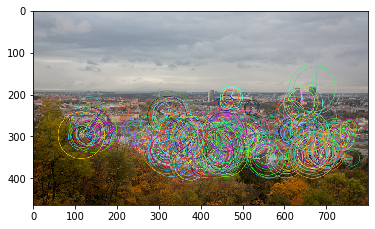

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)

out_img = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

OpenCV uses different conventions for the local feature scale. 

E.g. to get equivalent kornia LAF from ORB keypoints, one should you mrSize = 0.5, 
while for SIFT -- 6.0. The orientation convention is also different for kornia and OpenCV (but it is going
changed soon)

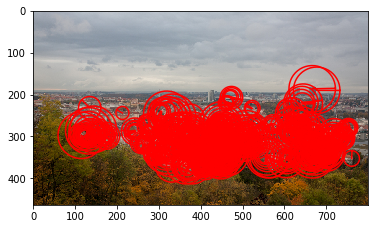

In [ ]:
lafs, r = laf_from_opencv_kpts(kps, 0.5, with_resp=True)
visualize_LAF(K.image_to_tensor(img, False), lafs, 0)

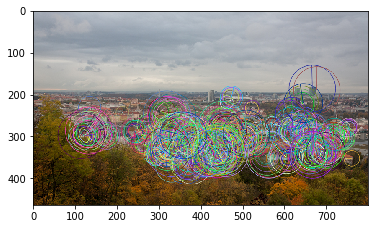

In [ ]:
kps_back = opencv_kpts_from_laf(lafs, 0.5, r)
out_img = cv2.drawKeypoints(img, kps_back, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

Now let's do the same for matches format

In [ ]:
#export
def cv2_matches_from_kornia(match_dists: torch.Tensor, match_idxs: torch.Tensor) -> List[cv2.DMatch]:
    return [cv2.DMatch(idx[0].item(), idx[1].item(), d.item()) for idx, d in zip (match_idxs, match_dists)]

def kornia_matches_from_cv2(cv2_matches, device=torch.device('cpu')):
    num_matches = len(cv2_matches)
    match_dists = torch.zeros(num_matches, 1, device=device, dtype=torch.float)
    match_idxs = torch.zeros(num_matches, 2, device=device, dtype=torch.long)
    for i, m in enumerate(cv2_matches):
        match_dists[i, 0] = m.distance
        match_idxs[i, 0] = m.queryIdx
        match_idxs[i, 1] = m.trainIdx
    return match_dists, match_idxs

        

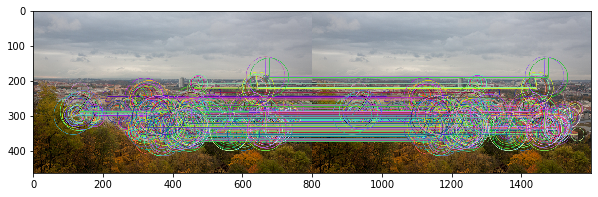

In [ ]:
from torch import allclose
match_dists, match_idxs = K.feature.match_nn(torch.from_numpy(descs).float(),
                                             torch.from_numpy(descs).float())

cv2_matches = cv2_matches_from_kornia(match_dists, match_idxs)
out_img = cv2.drawMatches(img, kps, img, kps, cv2_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,5))
plt.imshow(out_img)

match_dists_back, match_idxs_back = kornia_matches_from_cv2(cv2_matches)

assert(allclose(match_dists_back, match_dists))
assert(allclose(match_idxs_back, match_idxs))

In [ ]:
#export 
def laf_from_opencv_ORB_kpts(kpts: List[cv2.KeyPoint], 
                             device: torch.device=torch.device('cpu'),
                             with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    return laf_from_opencv_kpts(kpts, 0.5, device, with_resp)

def laf_from_opencv_SIFT_kpts(kpts: List[cv2.KeyPoint], 
                              device: torch.device=torch.device('cpu'),
                              with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    return laf_from_opencv_kpts(kpts, 6.0, device, with_resp)


def opencv_SIFT_kpts_from_laf(lafs, resps: Optional[torch.Tensor] = None):
    return opencv_kpts_from_laf(lafs, 6.0, resps);

def opencv_ORB_kpts_from_laf(lafs, resps: Optional[torch.Tensor] = None):
    return opencv_kpts_from_laf(lafs, 0.5, resps);


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted feature.ipynb.
Converted index.ipynb.
